<a href="https://colab.research.google.com/github/Aniket982-ux/RUL/blob/main/RUL_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras

# Unzip the archive
with zipfile.ZipFile("/content/archive (1).zip", "r") as z:
    z.extractall("/content/archive2")

# Paths
data_path = "/content/archive2/CMaps"


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow.keras.callbacks as callbacks


In [ ]:
test_list = []
rul_list = []
offset = 0
for fd in fds:
    df = pd.read_csv("/content/archive2/CMaps/test_" + fd + ".txt", sep="\s+", header=None)
    df[0] = df[0] + offset
    offset = df[0].max() + 1
    rul_df = pd.read_csv("/content/archive2/CMaps/RUL_" + fd + ".txt", sep="\s+", header=None)
    test_list.append(df)
    rul_list.append(rul_df)
test_data = pd.concat(test_list, ignore_index=True)
true_rul = pd.concat(rul_list, ignore_index=True)
test_data_first_column = test_data[0]
scaler_test = StandardScaler()
test_data_scaled = scaler_test.fit_transform(test_data.drop(columns=columns_to_be_dropped))
test_data = pd.DataFrame(np.c_[test_data_first_column, test_data_scaled])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow.keras.callbacks as callbacks


In [ ]:
def create_sequences(df, features, window_length, is_train=True):
    X, y = [], []
    for unit in df["unit"].unique():
        sub = df[df["unit"] == unit].sort_values("time").reset_index(drop=True)
        if is_train:
            target = sub["RUL"].values
        for i in range(len(sub) - window_length + 1):
            X.append(sub.iloc[i:i+window_length][features].values)
            if is_train:
                y.append(target[i+window_length-1])
    return np.array(X), (np.array(y) if is_train else None)

def get_last_windows(df, features, window_length):
    X_list, units = [], []
    for unit in df["unit"].unique():
        sub = df[df["unit"] == unit].sort_values("time").reset_index(drop=True)
        if len(sub) < window_length:
            pad_len = window_length - len(sub)
            # Replace repeat with tile and convert back to DataFrame
            padded_rows = pd.DataFrame(np.tile(sub.iloc[[0]].values, (pad_len, 1)), columns=sub.columns)
            sub = pd.concat([padded_rows, sub], ignore_index=True)
        X_list.append(sub.iloc[-window_length:][features].values)
        units.append(unit)
    return np.array(X_list), units

def create_model(input_shape):
    model = Sequential([
        layers.LSTM(128, input_shape=input_shape, return_sequences=True, activation="tanh"),
        layers.LSTM(64, return_sequences=True, activation="tanh"),
        layers.LSTM(32, activation="tanh"),
        layers.Dense(96, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model


In [ ]:
fds = ["FD001", "FD002", "FD003", "FD004"]
results = {}
features = ["time", "op1", "op2", "op3"] + [f"sensor_{i}" for i in range(1, 22)]
window_length = 30
shift = 1
early_rul = 125

for fd in fds:
    train_file = f"/content/archive2/CMaps/train_{fd}.txt"
    test_file = f"/content/archive2/CMaps/test_{fd}.txt"
    rul_file = f"/content/archive2/CMaps/RUL_{fd}.txt"

    train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
    test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
    true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)

    cols = ["unit", "time", "op1", "op2", "op3"] + [f"sensor_{i}" for i in range(1, 22)]
    train_df.columns = cols
    test_df.columns = cols

    train_df["RUL"] = train_df.groupby("unit")["time"].transform("max") - train_df["time"]

    scaler = StandardScaler()
    train_df[features] = scaler.fit_transform(train_df[features])
    test_df[features] = scaler.transform(test_df[features])

    X_train, y_train = create_sequences(train_df, features, window_length, is_train=True)
    X_test_last, test_units = get_last_windows(test_df, features, window_length)

    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=83)

    model = create_model((window_length, len(features)))
    early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    history = model.fit(X_train_split, y_train_split, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[early_stop], batch_size=128, verbose=0)

    pred = model.predict(X_test_last).reshape(-1)
    true_rul_arr = true_rul[0].values
    rmse = np.sqrt(mean_squared_error(true_rul_arr, pred))
    results[fd] = {"rmse": rmse, "true_rul": true_rul_arr, "pred": pred, "history": history.history}
    print(f"{fd} RMSE: {rmse:.2f}")


<ipython-input-6-76826a67ea6e>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
FD001 RMSE: 33.69


<ipython-input-6-76826a67ea6e>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
FD002 RMSE: 31.03


<ipython-input-6-76826a67ea6e>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
FD003 RMSE: 47.15


<ipython-input-6-76826a67ea6e>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
<ipython-input-6-76826a67ea6e>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  true_rul = pd.read_csv(rul_file, delim_whitespace=True, header=None)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
FD004 RMSE: 44.52


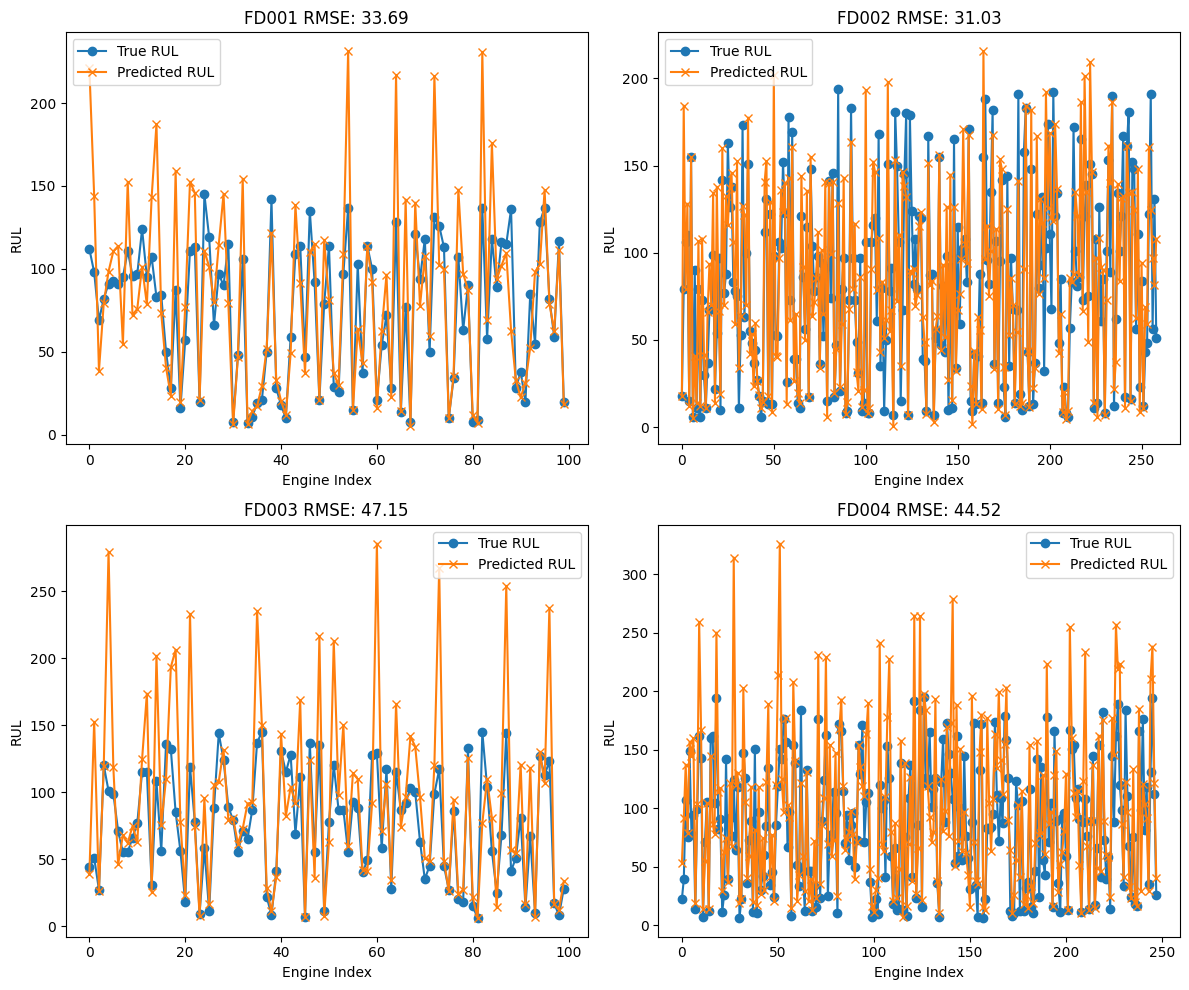

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, fd in zip(axes.flatten(), fds):
    res = results[fd]
    ax.plot(res["true_rul"], marker="o", label="True RUL")
    ax.plot(res["pred"], marker="x", label="Predicted RUL")
    ax.set_title(f"{fd} RMSE: {res['rmse']:.2f}")
    ax.set_xlabel("Engine Index")
    ax.set_ylabel("RUL")
    ax.legend()
plt.tight_layout()
plt.show()
